In [1]:
%matplotlib inline
from directSolve import DS
import numpy as np, matplotlib.pyplot as plt
import pystokes
import matelms as me

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

___________________

Try different simulator in case it's actually the ODE solver that goes wrong:

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
S0, D0  = -0.1, 0.0      # beta = 1 (positive beta is a puller (negative V2s))

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0,0 , 0., 0.])

#initial angle
th = np.zeros(3*Np)

#initial orientation: 50 deg towards each other
p0_  = np.array([0., 1., 0.])
p01_ = rotation(p0_, 0., 0., -25*2*np.pi/360)
p02_ = rotation(p0_, 0., 0., 25*2*np.pi/360)
p0   = np.zeros(3*Np)
p0[::Np]  = p01_
p0[1::Np] = p02_

# initial slip modes
S = np.zeros(5*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yy, yz
    S[i]       = S0*(3*p0[i]*p0[i] -1)
    S[i + Np]  = S0*(3*p0[i]*p0[i+Np])
    S[i + 2*Np]= S0*(3*p0[i]*p0[i+2*Np])
    S[i + 3*Np]= S0*(3*p0[i+Np]*p0[i+Np]-1)
    S[i + 4*Np]= S0*(3*p0[i+Np]*p0[i+2*Np])
    
    D[i]       = D0*p0[i]
    D[i+Np]    = D0*p0[i+Np]
    D[i+2*Np]  = D0*p0[i+2*Np]

In [5]:
def rhs(rth):
    """
    Function that gives rhs for equations dr/dt=v and d theta/dt=o
    """
    
    #position and angle theta (relative to initial angle)
    r = rth[0:3*Np]; th = rth[3*Np:6*Np]
    
    #placeholder for current rotation
    p = np.zeros(3*Np)
    
    
    #compute current orientation via initial orientation p0 and current angle th
    for i in range(Np):
        p[i], p[i+Np], p[i+2*Np] = rotation(np.array([p0[i],p0[i+Np],p0[i+2*Np]]), th[i], th[i+Np], th[i+2*Np])
                                            
        S[i]       = S0*(3*p[i]*p[i] -1)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i+Np]-1)
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+2*Np])
    
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    #no inertia, set velocities and angular velocities to zero
    #forces and torques could be set non-zero
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=1., ljr=2.1)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ds.directSolve(v, o, r, F, T, S, D)
    
    #return velocity and angular velocity as right-hand side
    return np.concatenate( (v,o) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [7]:
#initiallize system and forces
ds = DS(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system

rth0 = np.concatenate((r,th))
Tf = 100.
Npts = 100

X = simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000, method='Radau')

In [8]:
X.message

'Required step size is less than spacing between numbers.'

In [9]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [10]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

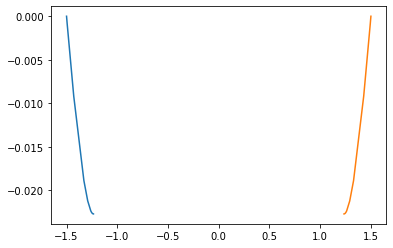

In [11]:
##x-y plot like in Ishikawa
plt.plot(pos1[:,0], pos1[:,1], pos2[:,0], pos2[:,1])

In [12]:
times

array([0.        , 0.0176359 , 0.19399487, 0.41050529, 0.4646329 ,
       0.4916967 , 0.49466427, 0.49763183, 0.49889018, 0.49999478,
       0.50012138, 0.5001372 , 0.5001423 , 0.5001474 , 0.50014804,
       0.50014812, 0.50014816, 0.50014816, 0.50014817, 0.50014817,
       0.50014817, 0.50014817, 0.50014817, 0.50014817, 0.50014817,
       0.50014817, 0.50014817, 0.50014817, 0.50014817, 0.50014817,
       0.50014817, 0.50014817])

In [13]:
np.amin(np.abs(pos1[:,0]-pos2[:,0]))

2.4697628001619343

 
Comments:

    -result has nothing to do with force - actually is the same without LJ potential
    -step size becomes too small - either a stiff problem or solution wrong
    -Try with different parameters:
        *(3t) only, and straight upwards polarisation: seems to work, they repell eachother
        *add (2s) with straight upwards polarisation: 
                - when S is negative, it does not work at all
                - when S is positive, it does work and they swim apart (stronger repulsion than (3t) alone even when S is 1e2 times smaller than D). When they are of the same order, we get: takes forever.
                - only S: positive, they separate. negative, they attracht each other --> seems to do something funny long before they overlap.
                --> Check what happens to matrix elements etc when xij smaller than 2

In [106]:
minIndex = np.where((pos1[:,0]- pos2[:,0])==np.amax(pos1[:,0]- pos2[:,0]))
#minIndex[0][0] -= 28
xjk,yjk,zjk = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]

In [107]:
xjk,yjk,zjk

(-2.4697628001619343, -2.9558647196559207e-13, 1.2156554337117817e-12)

In [108]:
theta = X.y.T[:,3*Np:6*Np]

##angles at minimum distance above
theta = theta[minIndex,:][0][0]

In [109]:
k=0

F, T, = np.zeros(3*Np), np.zeros(3*Np)
pol = np.zeros(3*Np)

for i in range(Np): #rotated relative from initial polarisation (defined as theta=0)
        pol[i], pol[i+Np], pol[i+2*Np] = rotation(np.array([p0[i],p0[i+Np],p0[i+2*Np]]), theta[i], theta[i+Np], theta[i+2*Np])
                                            
        S[i]       = S0*(3*pol[i]*pol[i] -1)
        S[i + Np]  = S0*(3*pol[i]*pol[i+Np])
        S[i + 2*Np]= S0*(3*pol[i]*pol[i+2*Np])
        S[i + 3*Np]= S0*(3*pol[i+Np]*pol[i+Np]-1)
        S[i + 4*Np]= S0*(3*pol[i+Np]*pol[i+2*Np])
    
        D[i]       = D0*pol[i]
        D[i+Np]    = D0*pol[i+Np]
        D[i+2*Np]  = D0*pol[i+2*Np]


rhs = np.zeros(22)
FH = np.zeros(22)

force_k  = np.array([F[k],F[k+Np], F[k+2*Np]])
torque_k = np.array([T[k],T[k+Np], T[k+2*Np]])
S_k = np.array([S[k],S[k+Np],S[k+2*Np],S[k+3*Np],S[k+4*Np]])
D_k = np.array([D[k],D[k+Np],D[k+2*Np]])
VH_k = np.concatenate([S_k,D_k,np.zeros(14)])

rhs += (np.dot(me.GH1s(xjk,yjk,zjk, b,eta), force_k) 
                                   + 1./b * np.dot(me.GH2a(xjk,yjk,zjk, b,eta), torque_k)
                                   - np.dot(me.halfMinusKHH(xjk,yjk,zjk, b,eta), VH_k))

#F2s = -ds.g2s*S_k
#F3t = -ds.g3t*D_k
#FH += np.concatenate([F2s,F3t,np.zeros(14)])

In [110]:
##current orientation of particle 1
pol[::Np]

array([4.08934712e-01, 9.12563642e-01, 1.79005120e-12])

In [111]:
lhs_inv = np.linalg.pinv(me.GHH(xjk,yjk,zjk, b,eta))
FH += np.dot(lhs_inv, rhs)
FH

array([-6.46477319e+08,  2.13136543e+00,  4.53683481e+02, -1.29295464e+09,
        4.37732718e-01, -1.48542301e+08, -3.42428220e+01,  1.98009688e+04,
       -6.38861012e-02, -4.58940391e+03,  1.97388951e+00, -1.27772204e-01,
       -3.77407619e+08, -5.50157388e+07,  3.47663025e+01, -8.43065013e+02,
       -4.58527905e+08,  2.73219911e-01,  3.48496428e+08,  3.47661576e+01,
        9.96924306e+03,  3.47662542e+01])

In [112]:
-np.dot(me.G1sH(xjk,yjk,zjk, b,eta), FH)

array([ 8.86038409e+06, -3.30429585e-02, -1.89330792e+01])

In [113]:
np.dot(me.K1sH(xjk,yjk,zjk, b,eta),VH_k)

array([-2.22914470e-04,  6.01793384e-03,  9.27733977e-15])

G1sH x FH gives huge values of velocity and angular velocity for both modes on 
What happens for one mode only?
(3t) minimum distance gives very normal values
(2s) negative: huge values 
(2s) positive: huge values

In [114]:
ds.G01s*force_k + 0.2*D_k

array([0., 0., 0.])

In [115]:
rhs

array([-3.16126162e-02,  5.42104408e-02,  1.12376603e-13,  7.76120281e-02,
        2.43526716e-13,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

As soon as (2s) is on and negative, G1sH x FH is huge. FH itself is huge. rhs is small, but lhs_inv is huge. 

Have to re-formulate problem, make G^HH invertible. 

1/2 - K^HH is probably not quite right, and G^HH invert. re-do solving for F^H

In [116]:
- np.dot(me.halfMinusKHH(xjk,yjk,zjk, b,eta), VH_k)

array([-3.16126162e-02,  5.42104408e-02,  1.12376603e-13,  7.76120281e-02,
        2.43526716e-13, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00])

In [117]:
np.dot(me.KHH(xjk,yjk,zjk, b,eta), VH_k)

array([-6.69675597e-03, -1.76640172e-03,  2.57449188e-15,  2.69616787e-03,
       -1.50363071e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [118]:
np.dot(lhs_inv, - np.dot(me.halfMinusKHH(xjk,yjk,zjk, b,eta), VH_k))

array([-6.46477319e+08,  2.13136543e+00,  4.53683481e+02, -1.29295464e+09,
        4.37732718e-01, -1.48542301e+08, -3.42428220e+01,  1.98009688e+04,
       -6.38861012e-02, -4.58940391e+03,  1.97388951e+00, -1.27772204e-01,
       -3.77407619e+08, -5.50157388e+07,  3.47663025e+01, -8.43065013e+02,
       -4.58527905e+08,  2.73219911e-01,  3.48496428e+08,  3.47661576e+01,
        9.96924306e+03,  3.47662542e+01])

In [119]:
np.dot(lhs_inv,np.dot(me.KHH(xjk,yjk,zjk, b,eta), VH_k))

array([ 6.82200703e+06, -6.94453357e-02, -4.78753355e+00,  1.36440139e+07,
       -4.62922184e-03,  1.56750527e+06,  2.92886965e-01, -2.08951409e+02,
        6.75624467e-04,  4.84300754e+01, -6.43165295e-02,  1.35124895e-03,
        3.98262601e+06,  5.80558265e+05, -3.92231155e-01,  8.89651531e+00,
        4.83865474e+06, -2.88942436e-03, -3.67753821e+06, -3.92229626e-01,
       -1.05201286e+02, -3.92230645e-01])

In [120]:
-np.dot(me.G1sH(xjk,yjk,zjk, b,eta),np.dot(lhs_inv,np.dot(me.KHH(xjk,yjk,zjk, b,eta), VH_k)))

array([-9.34999465e+04,  1.07670029e-03,  1.99792929e-01])

In [122]:
def hatGHH(xij,yij,zij, b,eta):
    return np.block([[me.G2s2s(xij,yij,zij, b,eta), me.G2s3a(xij,yij,zij, b,eta), me.G2s3s(xij,yij,zij, b,eta)],
                     [me.G3a2s(xij,yij,zij, b,eta), me.G3a3a(xij,yij,zij, b,eta), me.G3a3s(xij,yij,zij, b,eta)],
                     [me.G3s2s(xij,yij,zij, b,eta), me.G3s3a(xij,yij,zij, b,eta), me.G3s3s(xij,yij,zij, b,eta)]])

In [134]:
np.allclose(np.dot(np.linalg.inv(hatGHH(-xjk,-yjk,-zjk, b,eta)),hatGHH(xjk,yjk,zjk, b,eta)), np.identity(19))

False

In [136]:
np.dot(np.linalg.inv(hatGHH(xjk,yjk,zjk, b,eta)),hatGHH(xjk,yjk,zjk, b,eta))

array([[ 9.99999909e-01, -7.90556105e-21,  4.34560130e-20,
         1.28900922e-08, -5.92003393e-27, -9.74116820e-27,
         5.61894148e-20, -4.03545354e-20, -7.46522689e-27,
         7.41569957e-09,  2.75059406e-07,  9.19057119e-20,
        -1.38286596e-19, -4.08018549e-08,  5.18663786e-27,
        -1.12334868e-07, -1.85370563e-20,  2.75771805e-20,
        -1.93840892e-20],
       [ 2.69690455e-20,  1.00000000e+00, -1.32746199e-32,
        -5.87964771e-22,  4.55868109e-21, -2.86564874e-21,
        -5.93610734e-32, -1.37504732e-15,  3.83674772e-20,
        -5.41410424e-21, -6.26492707e-20,  6.81731238e-16,
        -7.20869325e-32,  5.35187453e-21,  1.27754501e-20,
         2.76648545e-20,  3.50362429e-17,  8.91254436e-33,
         3.85056899e-17],
       [ 8.13402139e-20,  2.06856125e-32,  1.00000000e+00,
        -4.38989124e-20,  4.38624827e-21,  2.24514341e-21,
         3.98855199e-16,  4.06147770e-32,  4.53349420e-21,
        -4.09199744e-20, -3.49267445e-19, -1.05412613e-31,
    

___________________
Below: used BDF directly (werid handling), works with (3t) mode only, but fails with (2s) mode

In [7]:
#initiallize system and forces
ds = DS(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system

rth0 = np.concatenate((r,th))
Tf = 100.
Npts = 100

X = simulate(rth0, Tf, Npts, rhs, 'BDF')

In [8]:
sol = np.empty(0)
i=0
while X.status=='running':
    X.step()
    sol = np.append(sol, X.y)
    i += 1

In [9]:
## number of steps taken
i

45

In [10]:
positions = np.zeros(int(sol.shape[0]/2))
angles = np.zeros(int(sol.shape[0]/2))

for k in range(i):
    positions[3*k*Np:3*(k+1)*Np] = sol[6*k*Np:(6*k+3)*Np]
    angles[3*k*Np:3*(k+1)*Np]    = sol[(6*k+3)*Np:6*(k+1)*Np]

In [11]:
positions1 = positions[::Np]
positions2 = positions[1::Np]

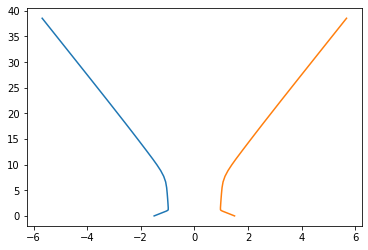

In [12]:
## x-y plot
plt.plot(positions1[::3],positions1[1::3],positions2[::3],positions2[1::3])

In [13]:
np.amin(np.abs(positions1[::3]-positions2[::3]))

1.9477701010126112